In [2]:
import sys, os
from matplotlib import pyplot
import numpy as np
from keras.datasets import cifar10
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import tensorflow as tf
import matplotlib.pyplot as plt
import math

In [3]:

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [4]:
# define cnn model
def define_model_VGG6():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
# CODE MODIFIED FROM TF: Save and load models
def eval_fresh_model():
    
    model = define_model_VGG6()
    # Evaluate the model
    trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    loss, acc = model.evaluate(testX, testY, verbose=2)
    print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))
    
    return model

untrained_model = eval_fresh_model()
untrained_model.summary()

313/313 - 4s - loss: 2.5969 - accuracy: 0.1022
Untrained model, accuracy: 10.22%
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x16669ab00> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1666aad30>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1666aad30> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1666cee80>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x1666ce710> and <tensorflow.python.keras.layers.core.Dropout object at 0x1666d6f28>).
313/313 - 4s - loss: 0.7466 - accuracy: 0.7390
(1, 32, 32, 3)
/Users/andrewweng/Developer/pyvenvs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
Trained VGG6 val accuracy: 73.90%
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output

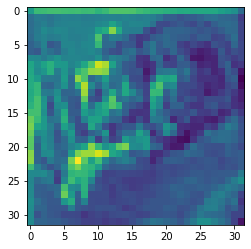

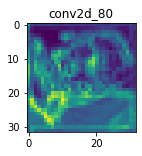

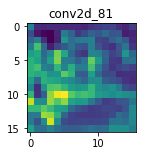

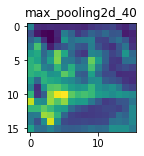

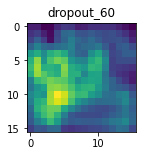

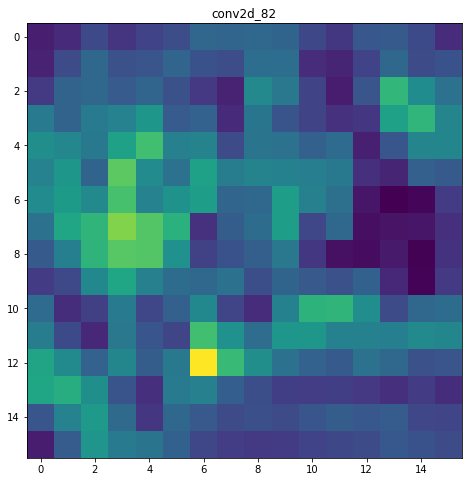

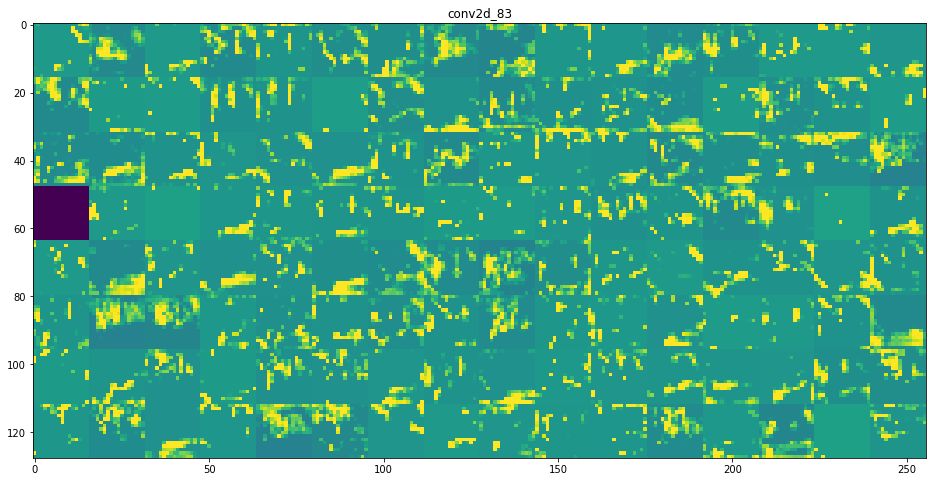

In [27]:
class VisualizeVggFeatures(keras.callbacks.Callback):

    def on_test_end(self,logs={}):

        model = self.model

        num_layers = 6

        trainX, trainY, testX, testY = load_dataset()
        trainX, testX = prep_pixels(trainX, testX)
            
        randomNoise = np.random.rand(1,32,32,3)
        randomNoise = randomNoise * 255
        randomNoise = testX[1,:,:,:].reshape(1,32,32,3)
        print(randomNoise.shape)


        layer_outputs = [layer.output for layer in model.layers[:num_layers]] # Gathers the outputs of the layers we want
        activation_model = Model(inputs=model.input, outputs=layer_outputs) # Isolates the model layers from our model
        activations = activation_model.predict(randomNoise) # Returns a list of five Numpy arrays: one array per layer activation

        images_per_row = 16

        layer_names = []
        for layer in model.layers[:num_layers]:
            layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
            

        for layer_name, layer_activation in zip(layer_names, activations): # Iterates over every layer
            n_features = layer_activation.shape[-1] # Number of features in the feature map
            output_size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
            n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
            layer_vis = np.zeros((output_size * n_cols, images_per_row * output_size))

            mean_act = np.mean(layer_activation,axis=3)
            plt.imshow(np.clip(mean_act[0,:,:], 0, 1),cmap='viridis')
      


            for col in range(n_cols):
                for row in range(images_per_row):
                    feature = layer_activation[0, :, :, col * images_per_row + row]
                    # Scale and transform the activation for display
                    feature -= feature.mean() # Subtract the mean
                    feature /= feature.std() # Normalize

                    # Don't allow the intensity values to be too large (max 200... over 200 is harsh to look at)
                    feature *= 50
                    feature += 150
                    feature = np.clip(feature, 0, 255).astype('uint8')

                    # displays a panel of 
                    layer_vis[col * output_size : (col + 1) * output_size, 
                                row * output_size : (row + 1) * output_size] = feature
            scale = 1. / output_size
            plt.figure(figsize=(scale * layer_vis.shape[1],
                                scale * layer_vis.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(layer_vis, aspect='auto', cmap='viridis')




# run the test harness for evaluating a model
def eval_trained_model_VGG6():

    file_dir = os.path.dirname(os.path.realpath('__file__')) #<-- absolute dir this file is in
    abs_file_path_chkpt = os.path.join(file_dir, 'vgg_6_vanilla_checkpoints/vgg6_vanilla.chkpt')
   
    model = define_model_VGG6()
    model.load_weights(abs_file_path_chkpt)
    # Evaluate the model
    trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
 
    plot_metrics = VisualizeVggFeatures()
    loss, acc = model.evaluate(testX, testY, verbose=2, callbacks = [plot_metrics])
    print("Trained VGG6 val accuracy: {:5.2f}%".format(100 * acc))
    
    return model

trained_model= eval_trained_model_VGG6()  
trained_model.summary()  